In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

np.set_printoptions(threshold=np.inf)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

In [23]:
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def Relu(Z):
    return np.maximum(0,Z)

def dRelu2(dZ, Z):    
    dZ[Z <= 0] = 0    
    return dZ

def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

class dlnet:
    def __init__(self, x, y):
        self.debug = 0;
        self.X=x
        self.Y=y
        self.Yh=np.zeros((1,self.Y.shape[1])) 
        self.L=2
        self.dims = [3, 2, 2, 1]  #3 input neurons, 2 neurons in each hidden layer, 1 output neuron
        self.param = {}
        self.ch = {}
        self.grad = {}
        self.loss = []
        self.lr=0.003
        self.sam = self.Y.shape[1]
        self.threshold=0.5
        
    def nInit(self):    
        np.random.seed(1)
        self.param['W1'] = np.array([[0.42,0.72,0.21],[0.11,0.3,0.65]]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))
        self.param['b1'] +=0.01
                
        
        self.param['W2'] = np.array([[0.17,0.29],[0.91,0.08]]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))                
        self.param['b2'] += 0.05 

        self.param['W3'] = np.array([[0.61,0.39]]) 
        self.param['b3'] = np.zeros((self.dims[3], 1))                
        self.param['b3'] += 0.08

        return 

    def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Sigmoid(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2

        Z3 = self.param['W3'].dot(A2) + self.param['b3']
        A3 = Sigmoid(Z3)
        self.ch['Z3'], self.ch['A3'] = Z3, A3


        self.Yh=A3
        loss=self.nloss(A3)
        return self.Yh, loss

    #using cross entropy loss 
    def nloss(self,Yh):
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss

    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))    

        dLoss_Z3 = dLoss_Yh * dSigmoid(self.ch['Z3'])    
        dLoss_A2 = np.dot(self.param["W3"].T, dLoss_Z3)
        dLoss_W3 = 1. / self.ch['A2'].shape[1] * np.dot(dLoss_Z3, self.ch['A2'].T)
        dLoss_b3 = 1. / self.ch['A2'].shape[1] * np.dot(dLoss_Z3, np.ones([dLoss_Z3.shape[1], 1]))

        
        dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])    
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
        
        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1

        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2

        self.param["W3"] = self.param["W3"] - self.lr * dLoss_W3
        self.param["b3"] = self.param["b3"] - self.lr * dLoss_b3

        
        
        return


    def pred(self,x, y):  
        self.X=x
        self.Y=y
        comp = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    
    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0
    
        print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
        
        return comp
    
    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
        
            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)

        plt.plot(np.squeeze(self.loss))
        plt.ylabel('Loss')
        plt.xlabel('Iter')
        plt.title("Lr =" + str(self.lr))
        plt.show()
    
        return 

In [24]:
#MY ID = 20K-0143

X = np.array([[1], [1], [5]]) #F1, F2, F3 
Y = np.array([[0]]) #Taking A as 0, B as 1




In [25]:
net = dlnet(X, Y)

Cost after iteration 0: 1.265128
Cost after iteration 500: 0.439579
Cost after iteration 1000: 0.299264
Cost after iteration 1500: 0.221621
Cost after iteration 2000: 0.173858
Cost after iteration 2500: 0.142077


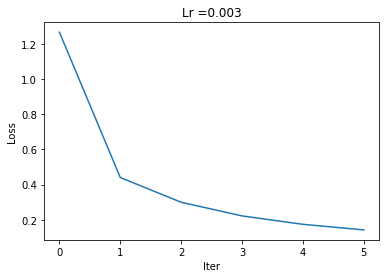

In [26]:
net.gd(X, Y)